# Predicting House Prices - Basic Regressions

My goal for this notebook is to predict house prices based on a Kaggle dataset of house attributes. This analysis will employ a few different models and will also serve as a discussion on strengths and weakness of the models used.

In [1]:
from datetime import datetime
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, normalize
import sklearn.feature_selection as fs
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.linear_model as lm
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import RandomForestRegressor

from IPython.display import Markdown as md
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_colwidth = 100
random_state = 11

In [2]:
df = pd.read_csv('train.csv')
Y = df['SalePrice']
df = df.drop(['SalePrice'], axis=1)

## Data Processing

Upon doing a quick inspection of the data, I've devised the following feature handling strategy: 
- variables with less than 20 unique values will be treated as categorical features, with the exception of
    - PoolArea
- the following features have more than 20 distinct values but will be treated as categorical
    - Neighborhood
- the following features have less than 20 unique values, but will more appropriately be treated as continuous features
    - BsmtFullBath
    - BsmtHalfBath
    - FullBath
    - HalfBath
    - BedroomAbvGr
    - KitchenAbvGr
    - TotRmsAbvGrd
    - Fireplaces
    - GarageCars
    - MoSold

In [3]:
not_converted = []
for col in df.columns:
    if (len(df[col].value_counts()) < 20):
        if col != 'PoolArea':
            df[col] = df[col].astype('category')
#             print(col + ' converted to Category')
    else:
        not_converted.append(col)
        
# Categorical variables that have more than 20 distinct values.
df['Neighborhood'] = df['Neighborhood'].astype('category')

# Variables with less than 20 distinct values, that are not categorical. They contain counts, and 
# will be treated as continuous/numeric.
to_convert = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
              'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
              'Fireplaces', 'GarageCars', 'YrSold']

for col in to_convert:
    # convert cols back to int. 
    df[col] = df[col].astype(int)
    
# Note to self - think about how to encode the cyclic 'month' variable

Observations: 
   - The variables that are approximately normally distributed or have a skew, tend to be related to square footage.
   - There are a handful of discrete numerical variables representing counts
   - There are about 9 variables that look like they have a very low-variability in information ie. have a high percentage of one value. These low-variablity features may include some useful signals WRT the target so we'll keep them for now.

### High percentage of NAs

Identifying variables with more than some percentage of NAs

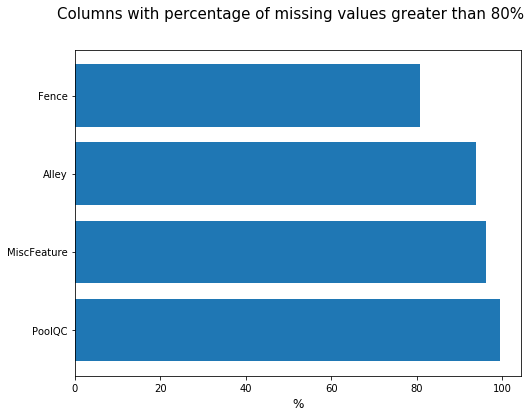

In [4]:
thresh = .8
nulls = df.isna().sum()

fig = plt.figure(figsize=(8, 6))
plt.barh(nulls[nulls > df.shape[0]*thresh].sort_values(ascending=False).index, 
         (nulls[nulls > df.shape[0]*thresh].sort_values(ascending=False)/df.shape[0]*100).values)
fig.suptitle('Columns with percentage of missing values greater than 80%', fontsize=15)
plt.xlabel('%', fontsize=12)
plt.show();

This plot suggests we should drop Alley, PoolQC, Fence, MiscFeature because they are over 80% null.
Upon looking at the data dict however, you'll see that the NAs represent the case where a house does not have a given feature, and are not actually `nulls`. 
Let this be a reminder to understand what the data represents.

### Fill missing values

In [5]:
# Fill numeric fields using the means of the respective neighborhoods
df['LotFrontage'] = df['LotFrontage'].fillna(value=df.groupby(by='Neighborhood')['LotFrontage'].transform('mean'))
df['MasVnrArea'] = df['MasVnrArea'].fillna(value=df.groupby(by=['Neighborhood', 'Exterior1st'])['MasVnrArea'].transform('mean'))
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])

# Separate out columns by data type to fill in remaining missing values
numerical_columns = df.select_dtypes(include=[np.int64, np.float64])
categorical_columns = df[df.select_dtypes(include=['category']).columns.union(['Id'])]

In [6]:
# Handling the two fields where the NaNs do not correspond to a known value.
# Fill 'Electrical' and 'MasVnrType' predictor using the means of the respective neighborhoods

def fill_na_group_by_neighborhood(df, col):
    agg = {col: 'count'}
    grouped = df.groupby(by=['Neighborhood', col]).agg(agg).rename(agg, axis=1).reset_index()
    max_by_neighborhood = grouped.iloc[grouped.groupby(by='Neighborhood').idxmax().reset_index()['count'].values]
    df = df.merge(max_by_neighborhood, how='left', on='Neighborhood')
    df[f'{col}_x'] = df[f'{col}_x'].fillna(value=df[f'{col}_y'])
    df = df.drop(columns=[f'{col}_y', 'count']).rename(columns={f'{col}_x':col})
    return df

categorical_columns = fill_na_group_by_neighborhood(categorical_columns, 'Electrical')
categorical_columns = fill_na_group_by_neighborhood(categorical_columns, 'MasVnrType')


# adding 'None' category to categorical fields, and then replacing NaN with 'None' so the records can be used in models
def add_category(df, col):
    df[col].cat.add_categories('None', inplace=True)

# identify number of nulls per column
null_categorical = categorical_columns.isna().sum().sort_values(ascending=False).reset_index()
null_categorical = null_categorical[null_categorical['index'] != 'Id']

# for each row in series, if there are n_nulls > 0, add 'None' as category and fill nulls with 'None'
for index, row in null_categorical.iterrows():
    if row[0] > 0:
        add_category(categorical_columns, row['index'])
        categorical_columns[row['index']] = categorical_columns[row['index']].fillna(value='None')

### Check for correlated variables

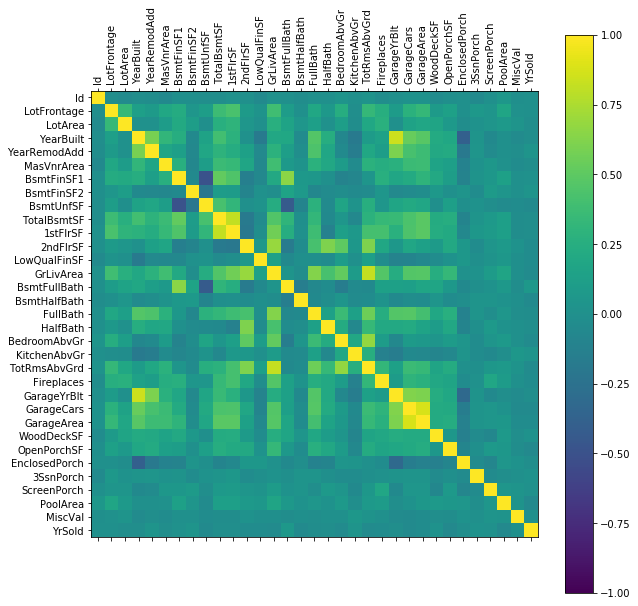

In [7]:
labels = numerical_columns.columns
corr_matrix = numerical_columns.corr()

corr_plt = plt.figure(figsize=(10,10))
plt.matshow(corr_matrix, vmin=-1, vmax=1, fignum=corr_plt.number)
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(labels)), labels);

From a visual inspection, it looks like the following pairs predictors are the most strongly correlated:

- GarageYrBlt, YearBuilt
- 1stFlrSF, TotalBsmtSF
- GarageArea, GarageCars
- TotRmsAbvGrd, GrLivArea
- BsmtUnfSf, BsmtFinSF1

Let's set a threshold of 75% 

In [8]:
threshold = .75

# this should capture the negative correlations as well

# create matrix with upper triangle and lower triangle (below the kth diagonal) distinguished by a bool 
empty_upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)

# filter the correlation matrix using empty_upper
corr_matrix_upper = corr_matrix.where(empty_upper)

# identify columns whose correlation coef is gt than the threshold
high_corr_cols = [col for col in corr_matrix_upper.columns if any(corr_matrix_upper[col] > .75)]
high_corr_cols
for each in high_corr_cols:
    filtering = corr_matrix[each] > threshold
    other = np.setdiff1d(filtering[filtering].index, each)[0]
    print(each, ',', other, ',',corr_matrix.loc[each, other])

# Dropping these highly correlated features just for the linear models
lin_numerical_columns = numerical_columns.drop(high_corr_cols, axis=1)

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']

1stFlrSF , TotalBsmtSF , 0.8195299750050355
TotRmsAbvGrd , GrLivArea , 0.8254893743088377
GarageYrBlt , YearBuilt , 0.8451406660104657
GarageArea , GarageCars , 0.8824754142814603


### Identifying and removing non-linear features 

If there are any non-linear features, they will be removed just for the linear models. We'll utilize the full dataset for non-linear models in the future.

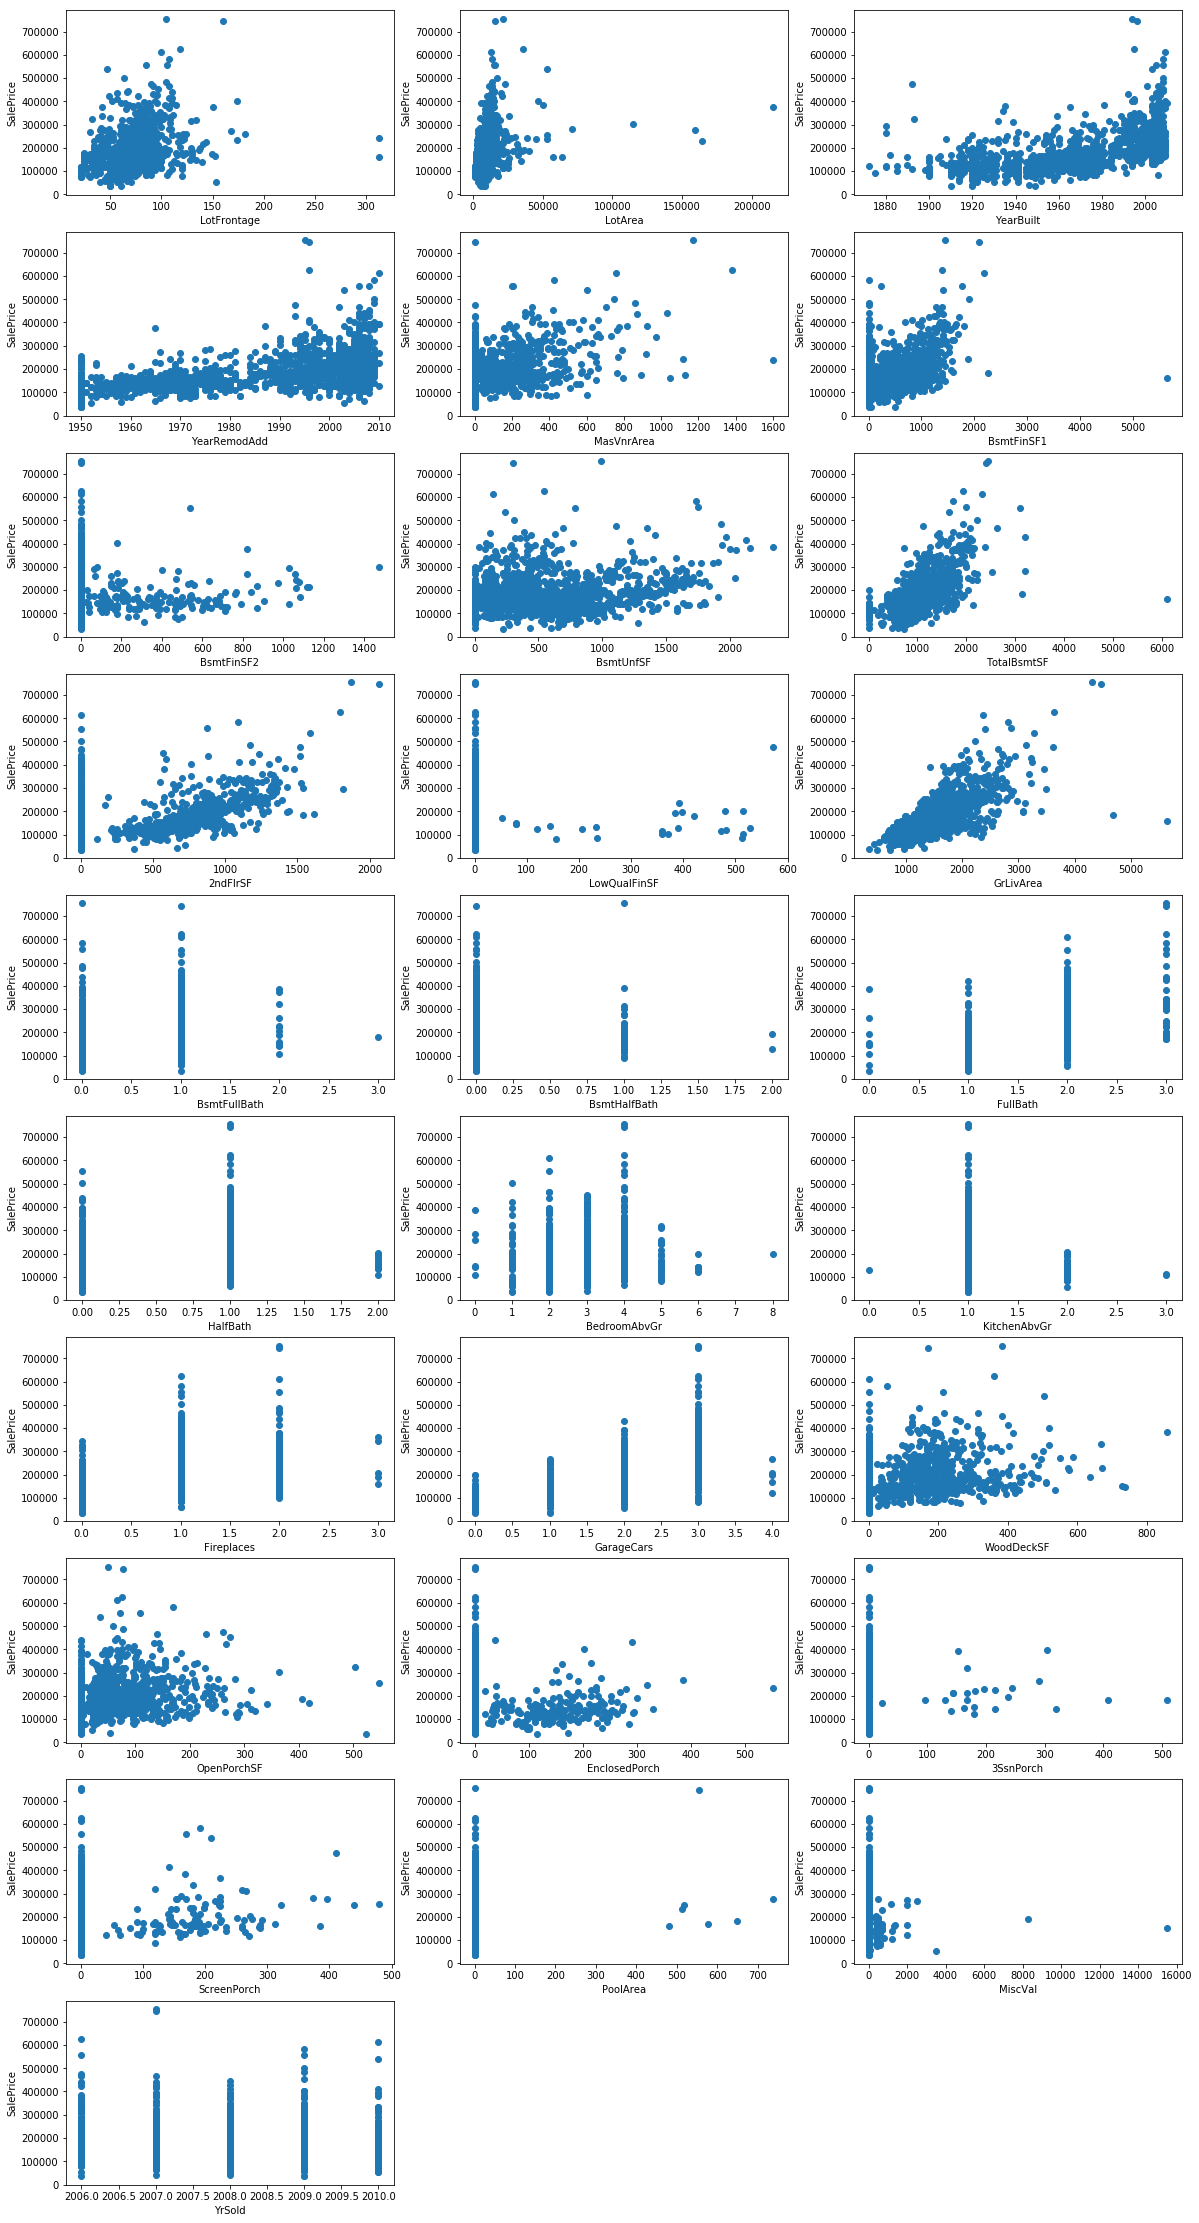

In [9]:
nrows=10
fig_lin_cols, ax = plt.subplots(nrows, 3, figsize=(20,40));

for j, col in enumerate(lin_numerical_columns.columns[1:]):
    _ = ax[j//3][j%3].scatter(lin_numerical_columns[col], Y)
    _ = ax[j//3][j%3].set_ylabel('SalePrice')
    _ = ax[j//3][j%3].set_xlabel(col);

# remove last two unused plots
ax[j//3][1].set_axis_off()
ax[j//3][2].set_axis_off()

From looking at these plots, it becomes evident that there are some attributes that don't apply to all homes. For example 'BsmtFinSF2', and '2ndFlrSF' each have have a value of 0 for more than a handful of homes. I'll handle this in the next notebook as part of an exploration of models which tolerate nans.

So based on these plots, it looks like the following predictors have a non-linear relationship with the target: 

'LotFrontage', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF2', 'BsmtUnfSF', 
                   'EnclosedPorch', 'OpenPorchSF', 'MiscVal', 'PoolArea', '3SsnPorch'

In [10]:
non_linear_cols = ['LotFrontage', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF2', 'BsmtUnfSF', 
                   'EnclosedPorch', 'OpenPorchSF', 'MiscVal', 'PoolArea', '3SsnPorch']
lin_numerical_columns.drop(non_linear_cols, axis=1, inplace=True)

### Join dataframes back together

In [11]:
lin_processed_df = lin_numerical_columns.join(categorical_columns.set_index('Id'), on='Id').drop(['Id'], axis=1)
X = pd.get_dummies(lin_processed_df, drop_first=True)

### Split data into Train, Test, Validation

In [12]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size=.8, random_state=random_state)
test_X, val_X, test_Y, val_Y = train_test_split(test_X, test_Y, train_size=.8, random_state=random_state)

### Utils

In [13]:
def eval_model(metrics):
    global model_performance
    if 'model_performance' not in globals():
        model_performance = pd.DataFrame(data={'model': [metrics[0]],'data': [metrics[1]],'R**2_train':[metrics[2]],'R**2_test':[metrics[3]],'RMSE ($)':[metrics[4]]})
    else:
        model_performance = model_performance.append({'model': metrics[0],'data': metrics[1],'R**2_train':metrics[2],'R**2_test':metrics[3],'RMSE ($)':metrics[4]},
                                                 ignore_index=True)
        model_performance = model_performance.drop_duplicates(subset=['model', 'data', 'R**2_train', 'R**2_test', 'RMSE ($)'])

### Predicting with linear models

In [14]:
# perform standardization of the data
# Center the data so the mean = 0, and stdev = 1
scalar_X = RobustScaler() # StandardScaler()

X_scaled = scalar_X.fit_transform(train_X)
test_X_scaled = scalar_X.transform(test_X)

# normalizing using the L2 norm 
X_scaled = normalize(X_scaled, norm='l1')
test_X_scaled = normalize(test_X_scaled, norm='l1')

# how does normalizing deal with outliers

In [15]:
# fit linear regression on X (original with dummy variables for categorical)
reg_lm_raw = lm.LinearRegression().fit(train_X, train_Y)
print('Prediction score of simple linear regression on raw data: ', reg_lm_raw.score(train_X, train_Y), '\n')

# fit linear regression on standardized and normalized data
reg_lm_scaled = lm.LinearRegression().fit(X_scaled, train_Y)
print('Prediction score of simple linear regression on scaled and normalized data: ', reg_lm_scaled.score(X_scaled, train_Y))

Prediction score of simple linear regression on raw data:  0.9394250076291197 

Prediction score of simple linear regression on scaled and normalized data:  0.8441240286023192


Scaling and normalizing the data did not yield a better prediction accuracy for the simple linear regression, but will be necessary for additional models used below. We'll primarily use X_scaled going forward.


### Predicting with the LASSO

In [16]:
# Lasso Regression | L1 norm aka sum(abs(Beta)). Regularizes the loss with lambda*sum(abs(Beta))
reg_lasso = lm.Lasso(alpha=1, 
                     fit_intercept=True, 
                     normalize=False, 
                     max_iter=10000
                    )\
              .fit(X_scaled, train_Y)

reg_lasso.score(X_scaled, train_Y)

0.8098323962132233

With just an alpha of 5, this model achieved a similar R^2 to the simple linear regression. Let's get a sense of how many input features can be dropped while still maintaining an acceptable model performance.

/Users/aditinabar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560579569592.938, tolerance: 703727950.1292837
  positive)
/Users/aditinabar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322912233765.19336, tolerance: 703727950.1292837
  positive)


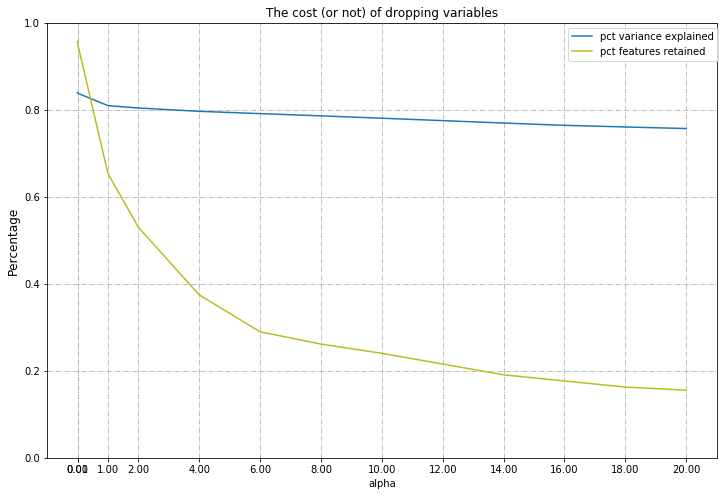

This plot shows that a penalty factor of alpha = 20, which drops about 84% of the input features,
would cost a -8.28 percentage point drop in captured variance. With that said, the optimal value of alpha
is the value after which the percent of features retained tapers off. Let's choose alpha = 6, which retains
~28% of features while capturing ~79% of the variance in the data.


In [17]:
regressions = []
scores = []
alphas = [.0001, .01, 1, 2, 4, 6, 8, 10, 12, 14, 16,18, 20] # np.arange(5, 100, 2)

for a in alphas:
    regression = lm.Lasso(alpha=a, 
                          fit_intercept=True, 
                          normalize=False, 
                          max_iter=100000
                         )\
                   .fit(X_scaled, train_Y)
    regressions.append(regression)
    scores.append(regression.score(X_scaled, train_Y))

# plt.figure()
fig, ax = plt.subplots(figsize=(12, 8))
color = 'tab:blue'
line1 = ax.plot(alphas, scores, color=color, label='pct variance explained')
_ = plt.xticks(alphas)
_ = plt.grid(True, linestyle='-.')
_ = plt.xlabel('alpha')
_ = plt.ylim([0, 1])
_ = plt.ylabel('Percentage', color='black', size=12)
_ = plt.title('The cost (or not) of dropping variables')

# collections.Counter returns dict with counts of each value in list. Using to get counts of 0
coefs = [collections.Counter(x.coef_)[0]/len(x.coef_) for x in regressions]

color = 'tab:olive'
line2 = ax.plot(alphas, 1 - np.array(coefs), color=color, label='pct features retained')
# plt2.set_ylabel('Fraction of features retained', color=color, size=12)
_ = plt.legend(bbox_to_anchor=(1.01,1))
plt.show();

print(f"This plot shows that a penalty factor of alpha = {max(alphas)}, which drops about {np.round(coefs[-1]*100,0).astype(int)}% of the input features," + 
      f"\nwould cost a {np.round((scores[-1] - scores[0]) * 100, 2)} percentage point drop in captured variance. With that said, the optimal value of alpha" +
      f"\nis the value after which the percent of features retained tapers off. Let's choose alpha = 6, which retains" +
      f"\n~28% of features while capturing ~79% of the variance in the data.")


In [18]:
# Lasso Regression with alpha=6
a = 6  # max(alphas)
lasso_6 = lm.Lasso(alpha=a, fit_intercept=True, max_iter=10000).fit(X_scaled, train_Y)
lasso_6.score(X_scaled, train_Y)

0.7914045901998281

### Evaluate generalizability of lasso and simple linear regression

In [19]:
eval_model(['OLS','raw, unprocessed data', reg_lm_raw.score(train_X, train_Y), reg_lm_raw.score(test_X, test_Y), mean_squared_error(test_Y, reg_lm_raw.predict(test_X), squared=False),])
eval_model(['OLS','standardized and normalized data', reg_lm_scaled.score(X_scaled, train_Y),reg_lm_scaled.score(test_X_scaled, test_Y), mean_squared_error(test_Y, reg_lm_scaled.predict(test_X_scaled), squared=False)])
eval_model(['LASSO-1','standardized and normalized data: 85% features retained', reg_lasso.score(X_scaled, train_Y), reg_lasso.score(test_X_scaled, test_Y), mean_squared_error(test_Y, reg_lasso.predict(test_X_scaled), squared=False),])
eval_model([ f'LASSO-{a}', 'standardized and normalized data: 28% features retained', lasso_6.score(X_scaled, train_Y), lasso_6.score(test_X_scaled, test_Y), mean_squared_error(test_Y, lasso_6.predict(test_X_scaled), squared=False)])
model_performance

# Calculate percent error

,model,data,R**2_train,R**2_test,RMSE ($)
0,OLS,"raw, unprocessed data",0.939,0.887,28028.003
1,OLS,standardized and normalized data,0.844,0.742,42317.876
2,LASSO-1,standardized and normalized data: 85% features retained,0.810,0.806,36652.822
3,LASSO-6,standardized and normalized data: 28% features retained,0.791,0.793,37922.611


Both the R^2 value and the Mean Squared Error of the linear regression on scaled data is deep in the negatives as we can see. The model's performance on the scaled test set appears to have suffered more of a performance hit than the LASSO analysis, which dropped 95% of the input features. 

### Regression with ElasticNet

In [20]:
# Elasticnet: uses both the Ridge and Lasso penalties. Drawback of Lasso is that if there are a number of correlated 
# variables, it will only select one, and deselect for the rest. 


\begin{equation*}
{\hat {\beta }}\equiv {\underset {\beta }{\operatorname {argmin} }}(\|y-X\beta \|^{2}+\lambda _{2}\|\beta \|^2_2+\lambda _{1}\|\beta \|_{1})
\end{equation*}

scikit-learn's elasticnet implementation allows you to attribute weights (which sum to 1) to each of the penalties. Setting $l1_{ratio} = 1 $ will apply the Lasso, or $L1$ norm, penalty and setting $l1_{ratio} = 0$ will apply the Ridge, or $L2$ norm penalty. When $0 < l1_{ratio} < 1$ will apply some fraction of both penalties. The following is the objective function the implementation aims to minimize

\begin{equation*}
{\frac{1}{2*n_{samples}} * ||y - X\beta||^2_2
+ \alpha * l1_{ratio} * ||\beta||_1
+ 0.5 * \alpha * (1 - l1_{ratio}) * ||\beta||^2_2}
\end{equation*}

In [21]:
# Start with the default implementation on the scaled input used for Lasso above.
# The data must be Fortran-contiguous. Checking X_scaled.flags verifies that this condition is met.

ElastNet = lm.ElasticNet(random_state=random_state)
ElastNet.fit(X_scaled, train_Y)
ElastNet.score(X_scaled, train_Y)
predictions_elastnet = ElastNet.predict(X_scaled)
testpredictions_elastnet = ElastNet.predict(test_X_scaled)

ElasticNet(random_state=11)

0.011887341920771122

In [22]:
mean_squared_error(testpredictions_elastnet, test_Y)

6869798207.628225

We're looking at an unremarkable performance out of the box. Let's tune the model.

In [23]:
# Increase max_iter to give the model the opportunity to converge
# Decrease alpha from 1 to 0.00005
# increase the weight of the lasso penalty (the l1 norm)

alpha=.00005
l1_ratio=.95

ElastNet2 = lm.ElasticNet(alpha=alpha,l1_ratio=l1_ratio, max_iter=1000000, tol=0.000001, random_state=random_state)
ElastNet2.fit(X_scaled, train_Y)
ElastNet2.score(X_scaled, train_Y)


ElasticNet(alpha=5e-05, l1_ratio=0.95, max_iter=1000000, random_state=11,
           tol=1e-06)

0.8112059654502164

In [24]:
elasticNet = lm.ElasticNet(random_state=random_state)
parameters = {'alpha': [10,5,1,.1,.00005], 
              'l1_ratio':[.95,.75,.5,.1,.00001], 
              'max_iter':[1000, 10000, 100000, 1000000],
              'tol': [0.0001, 0.00001, 0.000001]}
searchEN = GridSearchCV(elasticNet, parameters)
searchEN.fit(X_scaled, train_Y)

GridSearchCV(estimator=ElasticNet(random_state=11),
             param_grid={'alpha': [10, 5, 1, 0.1, 5e-05],
                         'l1_ratio': [0.95, 0.75, 0.5, 0.1, 1e-05],
                         'max_iter': [1000, 10000, 100000, 1000000],
                         'tol': [0.0001, 1e-05, 1e-06]})

Let's take a sneak peak at the best model identified by the GridSearch.

In [25]:
searchEN.score(X_scaled, train_Y)

0.8019082067383592

In [26]:
searchEN.best_estimator_
test = pd.DataFrame(searchEN.cv_results_)
test[test['rank_test_score'] == 1]

ElasticNet(alpha=5e-05, l1_ratio=0.75, random_state=11, tol=1e-05)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_max_iter,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
253,0.042,0.001,0.001,0.000,0.000,0.750,1000,0.000,"{'alpha': 5e-05, 'l1_ratio': 0.75, 'max_iter': 1000, 'tol': 1e-05}",0.789,0.758,0.809,0.728,0.750,0.767,0.029,1
256,0.042,0.001,0.001,0.000,0.000,0.750,10000,0.000,"{'alpha': 5e-05, 'l1_ratio': 0.75, 'max_iter': 10000, 'tol': 1e-05}",0.789,0.758,0.809,0.728,0.750,0.767,0.029,1
259,0.043,0.002,0.001,0.000,0.000,0.750,100000,0.000,"{'alpha': 5e-05, 'l1_ratio': 0.75, 'max_iter': 100000, 'tol': 1e-05}",0.789,0.758,0.809,0.728,0.750,0.767,0.029,1
262,0.043,0.002,0.001,0.000,0.000,0.750,1000000,0.000,"{'alpha': 5e-05, 'l1_ratio': 0.75, 'max_iter': 1000000, 'tol': 1e-05}",0.789,0.758,0.809,0.728,0.750,0.767,0.029,1


In [27]:
alpha = searchEN.best_params_["alpha"]
l1ratio = searchEN.best_params_["l1_ratio"]
eval_model(['ElasticNet', 'standardized and normalized data', ElastNet.score(X_scaled, train_Y), ElastNet.score(test_X_scaled, test_Y), mean_squared_error(test_Y, ElastNet.predict(test_X_scaled), squared=False)])
eval_model(['ElasticNet2: Manually tuned', 'standardized and normalized data', ElastNet2.score(X_scaled, train_Y), ElastNet2.score(test_X_scaled, test_Y), mean_squared_error(test_Y, ElastNet2.predict(test_X_scaled), squared=False)])
eval_model([f'ElasticNet - GridSearchCV: alpha={alpha}, l1_ratio={l1ratio}', 'standardized and normalized data', searchEN.score(X_scaled, train_Y), searchEN.score(test_X_scaled, test_Y), mean_squared_error(test_Y, searchEN.predict(test_X_scaled), squared=False)])
model_performance


,model,data,R**2_train,R**2_test,RMSE ($)
0,OLS,"raw, unprocessed data",0.939,0.887,28028.003
1,OLS,standardized and normalized data,0.844,0.742,42317.876
2,LASSO-1,standardized and normalized data: 85% features retained,0.810,0.806,36652.822
3,LASSO-6,standardized and normalized data: 28% features retained,0.791,0.793,37922.611
4,ElasticNet,standardized and normalized data,0.012,0.010,82884.246
5,ElasticNet2: Manually tuned,standardized and normalized data,0.811,0.803,37009.700
6,"ElasticNet - GridSearchCV: alpha=5e-05, l1_ratio=0.75",standardized and normalized data,0.802,0.790,38160.473


### Regression Model Evaluation

Interestingly, the Ordinary Least Squares model is showing the best performance: of all the models, it has captured the most variance in the test data, indicated by having the highest **R<sup>2</sup>\_test**, and also has the lowest mean squared error **RMSE ($)** when measured against the test data. 

We can see from both OLS models that there was _some_ loss of performance when run on the test data where as the rest of the models, even the abysmal, out-of-the-box ElasticNet, showed better generalizability when running on never before seen data. 

The performance of the Lasso was as expected. Since the LASSO drives select features to 0, the model inherently prioritizes interpretability over accuracy. As a result, both LASSO models faced a slight dip in performance as compared to the OLS. By increasing the shrinkage parameter from alpha=1 to alpha=6, which subsequently reduced the percent of features retained from ~85\% to ~28\%, we were able to train a model with significantly fewer features at a cost of 1.5\% in variance captured. 

Finally, the hyperparameter-tuned ElasticNet performed about the same as the LASSO, with the difference in the three Elastic Net models being a function of the model being tuned or not, and the model being trained using cross-validation, ie being trained on various subsets of the data, respectively.